In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Dataset import *
from Metric import *
from Model import *
from Preprocess import *
from tqdm.auto import trange
import torch.nn.functional as F

##Stateful Lstm

In [2]:
data = pd.read_csv("data/final.csv")

data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)
data.head()
m_data = data.copy()
m2_data = data.copy()

In [3]:
tst_size = 20
trn, tst = data[:-tst_size], data[-tst_size:]

In [ ]:
statefullstm = StatefulLoadData(data,20)
trn_scaled, tst_scaled = statefullstm.scaling()
#trn_scaled, tst_scaled

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
statefulmodel = StatefulLSTM(2,32,2,4)
statefulmodel.to(device)

In [ ]:
batch_size = 128
trn_x = torch.tensor(trn_scaled[:-1]).split(batch_size)
trn_y = torch.tensor(trn_scaled[1:]).split(batch_size)

tst_y = torch.tensor(tst_scaled)

In [ ]:
optim = torch.optim.AdamW(statefulmodel.parameters(), lr=0.002)

pbar = trange(50)
for e in pbar:
  statefulmodel.train()
  statefulmodel.reset_state()
  trn_loss = .0
  for x, y in zip(trn_x, trn_y):
    x, y = x.to(device), y.to(device)
    optim.zero_grad()
    p = statefulmodel(x)
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()
  trn_loss /= len(trn)-1

  statefulmodel.eval()
  with torch.inference_mode():
    p = statefulmodel.predict(y[-1:].to(device), len(tst_y))
    tst_loss = F.mse_loss(p, tst_y.to(device)).item()
  pbar.set_postfix({'trn_loss': trn_loss, 'tst_loss': tst_loss})

In [ ]:
scaler = statefullstm.get_scaler()
prd = scaler.inverse_transform(p.cpu()[:,:1])

In [ ]:
plt.title(f"LSTM (Stateful), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}, R2:{r2_score(prd,tst.to_numpy())}")
plt.plot(tst.Temperature.to_numpy(), label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

# ??

In [ ]:
torch.save(statefulmodel.state_dict(), './AdamW_0.002_StatefulLstm.pth')

# Stateless Lstm

In [ ]:
asdf = StatelessLoadData(data, 20, 64)
trn_dl , tst_dl = asdf.scaling()

In [ ]:
statelesslstm = StatelessLSTM(2,32,2,2)
statelesslstm.to(device)

In [ ]:
x,y =next(iter(trn_dl))
x.shape,y.shape

In [ ]:
type(x),type(y)

In [ ]:
optim = torch.optim.AdamW(statelesslstm.parameters(), lr=0.0001)

pbar = trange(50)
for e in pbar:
  statelesslstm.train()
  trn_loss = .0
  for x, y in trn_dl:
    #print(x.shape, y.shape)
    #print(y)
    x, y = x.to(device), y.to(device)
    optim.zero_grad()
    p = statelesslstm(x)
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()

  trn_loss /= len(trn)-1

  statelesslstm.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    p = statelesslstm.predict(x[0].to(device), len(tst_scaled))[:,:1]
    tst_loss = F.mse_loss(p, torch.tensor(tst_scaled[:,:1]).view(-1,1).to(device)).item()
  pbar.set_postfix({'trn_loss': trn_loss, 'tst_loss': tst_loss})

In [ ]:
scaler = asdf.get_scaler()
prd = scaler.inverse_transform(p.cpu())
# prd = p.cpu()

plt.title(f"LSTM (Look-back window), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}, R2:{r2_score(prd,tst.to_numpy())}")
plt.plot(tst.to_numpy()[:,:1], label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

# Single ANN

In [ ]:

anndataset = ANNLoadData(m_data,24,4,20,32)
trn_dl , tst_dl, trn_ds = anndataset.scaling()

In [ ]:
singleann = Net(24,4,512)

In [ ]:
x, y = next(iter(trn_dl))

x.shape, y.shape

In [ ]:
singleann.to(device)

optim = torch.optim.AdamW(singleann.parameters(), lr=0.0001)

pbar = trange(1000)
for i in pbar:
  singleann.train()
  trn_loss = .0
  for x, y in trn_dl:
    x, y = x.to(device), y.to(device)
    #print(x,y)
    p = singleann(x)
    #print(p)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    #print(loss)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(y)
  trn_loss = trn_loss/len(trn_ds)

  singleann.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.to(device), y.to(device)
    p = singleann(x)
    tst_loss = F.mse_loss(p,y)
    # tst_mape = mape(p,y)
    # tst_mae = mae(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})#, 'tst_mape':tst_mape.item(), 'tst_mae':tst_mae.item()})

In [ ]:
singleann.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.to(device), y.to(device)
  p = singleann(x)
  
scaler = anndataset.get_scaler()
y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

res_dict = {}

plt.title(f"Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'NN(9,512,4)': {'MAPE':mape(p,y), 'MAE':mae(p,y)}})

In [ ]:
# 장기예측
window_size = 24
prediction_size = 4
preds = []
tst_data  = data [-tst_size :]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
singleann.to(device)

# print(type(x), type(y))
x, y = trn_ds[len(trn_ds)-1]

for _ in range(tst_size):
  #print(x.shape, y.shape)
  y=y.squeeze()
  #print(x.shape, y.shape)

  x = np.concatenate([x,y])[-window_size:]
  #x = x.flatten()
  #y = y.flatten()
    
  x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
  #y = net(torch.tensor(x, dtype=torch.float32).to(device)) # your model
  y=singleann(x_tensor)
  y = y.detach().cpu().numpy()
  y= y.reshape(1,prediction_size)
  #print(x,y)
  preds.append(y)

preds = np.concatenate(preds, axis=0)
preds = scaler.inverse_transform(preds).squeeze()
print(preds.shape)
preds = preds[:,0]
print(preds.shape)

mape2 = mape(preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
df = pd.DataFrame({"ANN_long": preds}, index=tst_data.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

# Multichannel ANN

In [5]:
#m_data = data.copy()
m2_data['rolling_mean'] = data.rolling(12).mean()
m2_data['diff1'] = data.diff(1)
m2_data = m2_data.dropna()

multidata = MultiANNLoadData(m2_data,24,4,20,32)
trn_dl, tst_dl , trn_ds = multidata.scaling()

In [6]:
a,b = next(iter(trn_dl))
a.shape,b.shape

(torch.Size([32, 24, 3]), torch.Size([32, 4, 3]))

In [7]:
multimodel = NetMulti(24,4,512,3)

- 40개월   ex) 60을 보고 40을 예측  /  1개월씩 40을 예측  /  4개월씩 10번
- 목표를 설정하고 그것을 이루기 위해 시도한 방법들 소개!

In [9]:
multimodel.cuda()

optim = torch.optim.AdamW(multimodel.parameters(), lr=0.0001)

pbar = trange(1000)
for i in pbar:
  multimodel.train()
  trn_loss = .0
  for x, y in trn_dl:
    x, y = x.to(device), y.to(device)   # (32, 24, 3), (32, 4, 3)
    #print(x.shape, y.shape)
    p = multimodel(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(y)
  trn_loss = trn_loss/len(trn_ds)

  multimodel.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.to(device), y.to(device)
    p = multimodel(x)
    tst_loss = F.mse_loss(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})


  0%|          | 0/1000 [00:00<?, ?it/s]

# 단기

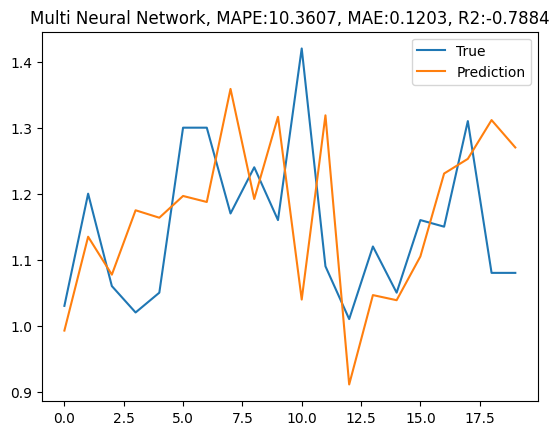

In [11]:
scaler = multidata.get_scaler()
res_dict = {}

multimodel.eval()
multimodel.to('cuda')
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  #print(y.shape) #17,4,3
  y=y.reshape(-1,3)
  y=scaler.inverse_transform(y.cpu().numpy())
  y=y.reshape(-1,4,3)
  x, y = x.flatten(1), y[:,:,0] #17,4    0번째 채널을 뽑고있다.


  x = x.to('cuda')
  #p = Multinet(x)[:,:,0]
  p = multimodel(x)
  #print(p.shape)
  p = p.reshape(-1,3)
  p=p.cpu()
  p=scaler.inverse_transform(p.numpy())
  #print(p.shape)
  p = p.reshape(-1,4,3)


#print(y,p)
#print(y.shape,p.shape)

#y = y.cpu()/scaler.scale_[0] + scaler.min_[0]
#p = p.cpu()/scaler.scale_[0] + scaler.min_[0]

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])
#print(y,p)
#print(y.shape,p.shape)
p = p[:,0]
#inverse_preds = scaler.inverse_transform(p.reshape(-1,3))


plt.title(f"Multi Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'NN(9*2, 512, 4)': {'MAPE':mape(p,y), 'MAE':mae(p,y),  'R2':r2_score(p,y)}})

# 장기

In [12]:
# 장기예측
window_size = 24
prediction_size = 4
test_size=20
preds = []

tst_data = data[-tst_size:]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
multimodel.to(device)

# print(type(x), type(y))
x, y = trn_ds[len(trn_ds)-1]
print(y)
print(x.shape , y.shape)

[[0.8028985  0.96783626 0.49456525]
 [0.71304345 0.93650794 0.30978262]
 [0.7855072  0.9177109  0.6141305 ]
 [0.76231885 0.90601504 0.43478262]]
(24, 3) (4, 3)


(20,)
MAPE:  16.145344544867896
MAE:  0.18684974443912505
R2_Score:  -2.5999766843194556


<Axes: xlabel='YearMonth'>

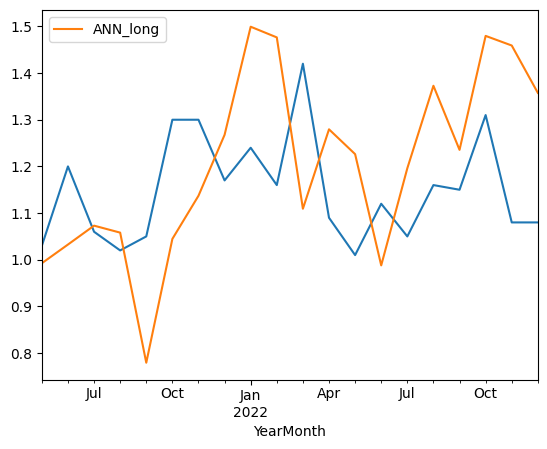

In [13]:
preds = []

for i in range(test_size):
  y = y.squeeze()
  # print(i, x.shape, y.shape)
  x = np.concatenate([x,y])[-window_size:]
    
  x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
  # print(x_tensor.shape)
  y = multimodel(x_tensor)
  # print(y.shape)
  y = y.detach().cpu().numpy()
  # y = y.reshape(1,prediction_size)
  #print(x,y)
  preds.append(y)
  # print(i, x.shape, y.shape)


preds = np.concatenate(preds, axis=0)
# print(preds.shape)
# expanded_preds = np.zeros((preds.shape[0], 3))  
# expanded_preds[:, 0] = preds[:, 0]  


inverse_preds = scaler.inverse_transform(preds.reshape(-1,3)).reshape(-1,4,3)


final_preds = inverse_preds[:, 0,0]
print(final_preds.shape)
#print(preds.shape)
#y = y/scaler.scale_[0] + scaler.min_[0]
#preds = preds/scaler.scale_[0] + scaler.min_[0]
#preds = scaler.inverse_transform(preds).squeeze()
#print(preds.shape)
#preds = preds[:,0]
#print(preds.shape)

mape2 = mape(final_preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(final_preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(final_preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
df = pd.DataFrame({"ANN_long": final_preds}, index=tst_data.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)